# Graph Neural Networks (GCN/GraphSAGE,GAT) for Graph Classification on the Pyramidal Reservoir Graph Neural Network easy Dataset

## Overview
This notebook demonstrates the use of Graph Neural Networks (GNNs) specifically: Grapch Covlutional Network (GCN), GraphSAGE and Graph Attention (GAT) networks to classify graph data from the small dataset: https://github.com/FilippoMB/Benchmark_dataset_for_graph_classification/tree/master

## Dataset details
The dataset consists of graphs belonging to 3 different classes. The number of nodes in each graph is variable and the feature vector on each node is a one-hot vector of size 5, which encodes the color of the node. The class is determined by the relative position of the colors on the graph.

## Notebook Content
1. **Data Loading**: Importing the dataset,and transforming the dataset for model input.
2. **Model Architecture**: Implementing GCN, GraphSAGE and GAT networks for classification.
3. **Training the Model**: Running experiments and tuning hyperparameters.
4. **Evaluation**: Assessing model performance using metrics such as accuracy and precision.
5. **Results & Discussion**: Analyzing model predictions by using accuracy and confusion matrix.

In [1]:
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch


from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

## 1. Extract Data for Training, Validation, and Test
We need to extract the training, validation, and test data, including adjacency matrices, node features, and labels. Let's process this into the appropriate format.

In [2]:
# Load the raw dataset
data = np.load("easy.npz", allow_pickle=True)

# Inspect keys in the file
print("Keys in the dataset:", list(data.keys()))

Keys in the dataset: ['tr_adj', 'tr_feat', 'tr_class', 'val_adj', 'val_feat', 'val_class', 'te_adj', 'te_feat', 'te_class']


## 2. Convert Data to PyTorch Geometric Format
We will convert the adjacency matrices and features into PyTorch Geometric Data objects for graph classification.

In [3]:
from torch_geometric.data import Data, Dataset

class GraphDataset(Dataset):
    def __init__(self, adj_matrices, features, labels, transform=None):
        """
        Initialize dataset by pre-processing all graphs into PyG `Data` format.
        
        Args:
            adj_matrices (list of np.array): List of adjacency matrices.
            features (list of np.array): List of node feature matrices.
            labels (list of int): List of graph labels.
            transform (callable, optional): Optional transform to apply to data.
        """
        super().__init__(transform)
        self.graphs = []  # Store processed graphs

        for i in range(len(adj_matrices)):
            # Convert adjacency matrix to edge index
            edge_index = torch.tensor(np.array(adj_matrices[i].nonzero()), dtype=torch.long)
            
            # Convert node features
            x = torch.tensor(features[i], dtype=torch.float)

            # Ensure `y` is a single integer label
            #labels[i].nonzero()[0] to encode the label from a one-hot-encoding rappresentation 
            #into a numerical version
            y = torch.tensor(labels[i].nonzero()[0], dtype=torch.long).unsqueeze(0) 

            # Create Data object and store it
            self.graphs.append(Data(x=x, edge_index=edge_index, y=y))

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]  # Return pre-processed graph


In [4]:
# Extract train, validation, and test data
train_adj = data['tr_adj']  # Adjacency matrices for training
train_feat = data['tr_feat']  # Node features for training
train_labels = data['tr_class']  # Graph-level labels for training

val_adj = data['val_adj']  # Adjacency matrices for validation
val_feat = data['val_feat']  # Node features for validation
val_labels = data['val_class']  # Graph-level labels for validation

test_adj = data['te_adj']  # Adjacency matrices for test
test_feat = data['te_feat']  # Node features for test
test_labels = data['te_class']  # Graph-level labels for test


# Create datasets
train_dataset = GraphDataset(train_adj, train_feat, train_labels)
val_dataset = GraphDataset(val_adj, val_feat, val_labels)
test_dataset = GraphDataset(test_adj, test_feat, test_labels)

print(f"Train dataset length: {len(train_dataset)}, Validation dataset length: {len(val_dataset)}, Test dataset length: {len(test_dataset)}")

Train dataset length: 1475, Validation dataset length: 162, Test dataset length: 163


### 2.1 Check how the Data is handling the graphs

In [5]:
train_dataset[0] #Show the characteristics of the first graph. It is composed by 126 nodes, each described by 5 columns. The edge_index show origin and destination of the 816 edges, while the y is 1 value  

Data(x=[126, 5], edge_index=[2, 816], y=[1, 1])

In [6]:
train_dataset[1] #Show the characteristics of the second graph. It is composed by 162 nodes, each described by 5 columns. The edge_index show origin and destination of the 994 edges, while the y is 1 value  

Data(x=[162, 5], edge_index=[2, 994], y=[1, 1])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)

In [8]:
batch = next(iter(train_loader))
batch 
#x = [288, 5]: Node features: 288 total nodes, each with 5 features.
#edge_index = [2, 1810] Edges: A list of 1810 edges, stored as source-destination node pairs.
#y=[2, 1] = Graph labels: 19 graphs in the batch, each with a single class label.
#batch=[288] = Graph indices: Maps each node to its respective graph in the batch.
#ptr=[3] = Graph separators: Pointer array marking where each graph starts in x and edge_index.

DataBatch(x=[288, 5], edge_index=[2, 1810], y=[2, 1], batch=[288], ptr=[3])

In [9]:
# Extract the batch from the dataloader to check how it handles the graphs internally
batch = next(iter(train_loader))

# Get the number of graphs in the batch
num_graphs = batch.y.size(0)

# Extract individual graphs
graphs = []
for i in range(num_graphs):
    print("Graph",i)
    # Get the node indices for graph i
    node_mask = batch.batch == i
    node_indices = node_mask.nonzero(as_tuple=True)[0]
    print("Number of nodes:", node_mask.sum())

    # Extract nodes and features
    x_i = batch.x[node_indices]

    # Extract edges that belong to this graph
    edge_mask = torch.isin(batch.edge_index[0], node_indices)  # Only source nodes
    print("Number of edges:", edge_mask.sum())
    edge_index_i = batch.edge_index[:, edge_mask]

    # Adjust indices so they start from 0
    mapping = {old.item(): new for new, old in enumerate(node_indices)}
    edge_index_i = torch.tensor([[mapping[n.item()] for n in edge_index_i[0]],
                                 [mapping[n.item()] for n in edge_index_i[1]]], dtype=torch.long)
    
    print("Label",batch.y[i])
    # Extract label
    y_i = batch.y[i]

Graph 0
Number of nodes: tensor(126)
Number of edges: tensor(816)
Label tensor([0])
Graph 1
Number of nodes: tensor(162)
Number of edges: tensor(994)
Label tensor([0])


## 3. Visualize an Example Graph
We can visualize one of the graphs from the dataset to ensure everything looks correct.

In [10]:
# Serach the smallest graph to plot to ease the visualization
smallest = 0
size_small = 170
for i in range(len(train_dataset)):
    if(size_small > len(train_dataset[i].x)):
        size_small = len(train_dataset[i].x)
        smallest = i
print("smallest graph id",smallest,"size",size_small,"nodes")

smallest graph id 12 size 99 nodes


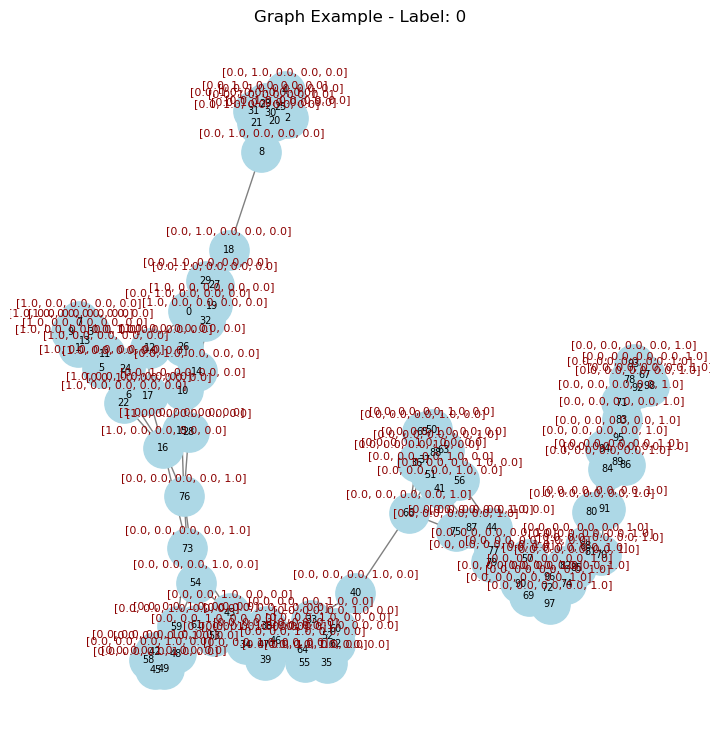

In [11]:
#Plot the graph using the networkx library
def plot_graph(data):
    """Visualize a PyTorch Geometric graph with node and edge features."""
    G = to_networkx(data, to_undirected=True)
    
    # Get node positions for consistent layout
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph structure
    plt.figure(figsize=(7, 7))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', 
            node_size=800, font_size=7)

    # Format node features
    node_labels = {i: f"{[round(f, 2) for f in data.x[i].tolist()]}" for i in range(data.x.shape[0])}

    # Display node features slightly above nodes
    offset = 0.05  # Adjust for better visibility
    pos_shifted = {k: (v[0], v[1] + offset) for k, v in pos.items()}
    nx.draw_networkx_labels(G, pos_shifted, labels=node_labels, font_size=8, font_color="darkred")

    # Add edge features if available
    if hasattr(data, "edge_attr") and data.edge_attr is not None:
        edge_labels = {(u, v): f"{[round(e, 2) for e in data.edge_attr[idx].tolist()]}" 
                       for idx, (u, v) in enumerate(data.edge_index.T.tolist())}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color="darkblue")

    plt.title(f"Graph Example - Label: {data.y.item()}")
    plt.show()

# Plot the smallest graph
plot_graph(train_dataset[12])


## 4. Create DataLoaders
Now, let's prepare the data loaders for training, validation, and testing.

In [12]:
# Create DataLoader for batching
# NOTICE: This data loader is from torch_geometric.loader!! It is not from torch.utils.data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train loader: {len(train_loader)}, Validation loader: {len(val_loader)}, Test loader: {len(test_loader)}")

Train loader: 93, Validation loader: 11, Test loader: 11


## 5. Define the GNN Model
  - GCN (Graph Convolutional Network) → Simple message passing
  - GraphSAGE (Sample & Aggregate) → Uses neighbor sampling
  - GAT (Graph Attention Network) → Uses attention mechanism

In [13]:
#GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Aggregate node features. From Node to Graph Features
        x = self.fc(x)
        return x

#GraphSAGE Model
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)# Aggregate node features. From Node to Graph Features
        x = self.fc(x)
        return x

#GAT Model (Graph Attention Network)
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch) # Aggregate node features. From Node to Graph Features
        x = self.fc(x)
        return x


## 6. Define Training Loop and Testing function

In [14]:
# Function to visualize model performance by creating a confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, dataset_name, model_name):
    """
    Creates and displays a confusion matrix to evaluate classification performance.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        class_names: List of class names for axis labels
    """
    cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix +" +dataset_name+ " "+ model_name)
    plt.show()

def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion):
    """
    Train the model for a specified number of epochs and track the training and validation losses.
    
    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        train_dataset: The entire training dataset.
        val_dataset: The entire validation dataset.
        device: Device to run the model on (CPU or GPU).
        optimizer: The optimization algorithm to use for updating model parameters.
        criterion: The loss function to use for computing the loss.
    
    Returns:
        None: The function plots the training and validation loss over the epochs.
    """
    

    # Record the start time
    start_time = time.time()


    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):  # Train for epochs
        train_loss = 0
        val_loss = 0
        model.train()  # Set model to training mode       
        for batch in train_loader:
            batch = batch.to(device)  # Move batch to GPU
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(batch)  # Forward pass
            loss = criterion(outputs, batch.y.squeeze())  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * batch.size(0)
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)  # Store training loss

        # Compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for batch in val_loader:
                batch = batch.to(device)  # Move batch to GPU
                val_outputs = model(batch)  # Forward pass
                loss = criterion(val_outputs, batch.y.squeeze())  # Compute validation loss. .squeeze() is used to reduce from 2D to 1D vector
                val_loss += loss.item() * batch.size(0)
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)  # Store validation loss        
            if (epoch + 1) % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

            
    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')    
            
    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
        
    return

def testing_model(model, dataloader, device, dataset_name, model_name):
    """
    Evaluate the model on a given dataloader and compute accuracy.
    
    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).
    
    Returns:
        float: Accuracy of the model on the test dataset.
    """
    # Record the start time
    start_time = time.time()
   
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch in dataloader:
            batch = batch.to(device)  # Move batch to GPU
            outputs = model(batch)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            all_labels.extend(batch.y.squeeze().cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Define class names
    class_names = [f"Class {cls}" for cls in np.unique(all_labels)]

    # Plot the confusion matrix
    plot_confusion_matrix(all_labels, all_predictions, class_names, dataset_name, model_name)
    
    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')    
    
    return accuracy

## 8. Define the model
 - Architectures
 - Loss function
 - Optimizer
 
**Train the models**

cuda
Epoch 20/50, Train Loss: 59.2028, Val Loss: 57.0974
Epoch 40/50, Train Loss: 32.2608, Val Loss: 35.4057
The function took 23.5153 seconds to execute.


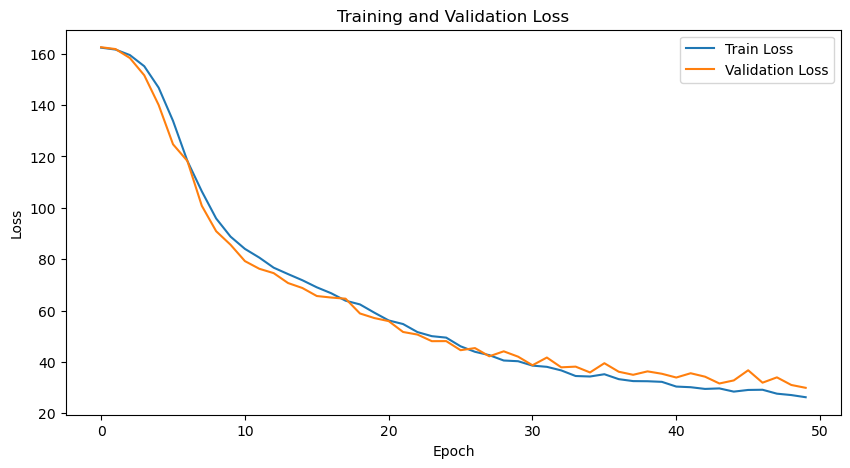

Epoch 20/50, Train Loss: 42.1248, Val Loss: 47.3123
Epoch 40/50, Train Loss: 23.8761, Val Loss: 29.4723
The function took 21.4801 seconds to execute.


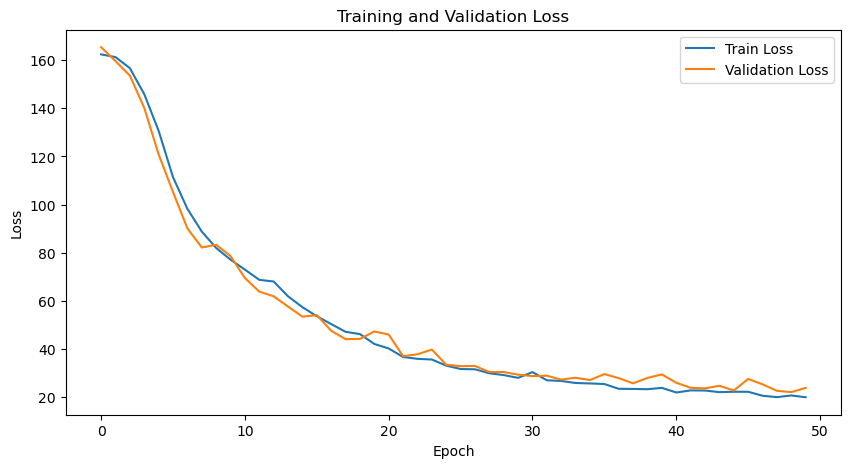

Epoch 20/50, Train Loss: 20.6206, Val Loss: 21.6229
Epoch 40/50, Train Loss: 16.3417, Val Loss: 16.8859
The function took 33.5359 seconds to execute.


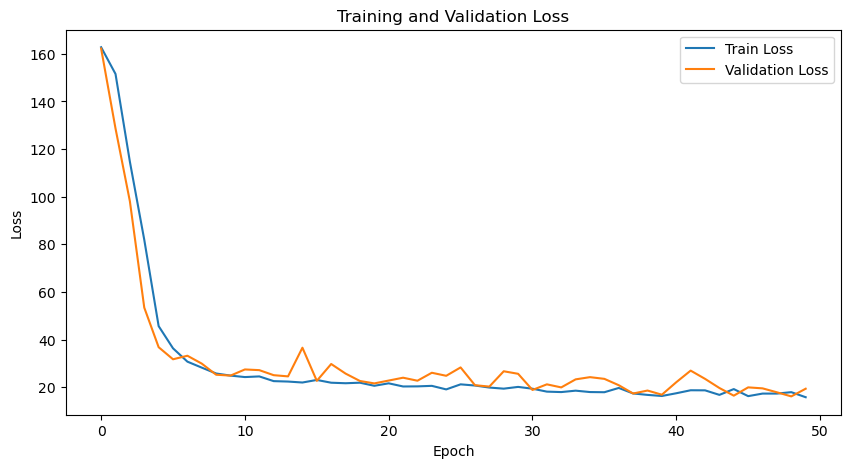

In [15]:
criterion = nn.CrossEntropyLoss()
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

GCNmodel = GCN(input_dim=train_feat[0].shape[1], hidden_dim=64, output_dim=3)
GCNmodel.to(device)
optimizer = optim.Adam(GCNmodel.parameters(), lr=0.001)
training_loop(GCNmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

GraphSAGEmodel = GraphSAGE(input_dim=train_feat[0].shape[1], hidden_dim=64, output_dim=3)
GraphSAGEmodel.to(device)
optimizer = optim.Adam(GraphSAGEmodel.parameters(), lr=0.001)
training_loop(GraphSAGEmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

GATmodel = GAT(input_dim=train_feat[0].shape[1], hidden_dim=64, output_dim=3)
GATmodel.to(device)
optimizer = optim.Adam(GATmodel.parameters(), lr=0.001)
training_loop(GATmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

## 9. Test the model

GCNmodel


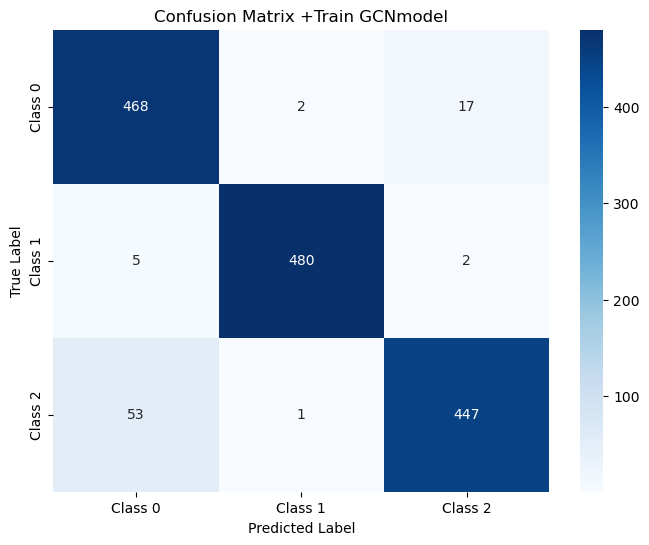

The function took 0.3719 seconds to execute.
Train Accuracy: 94.5763


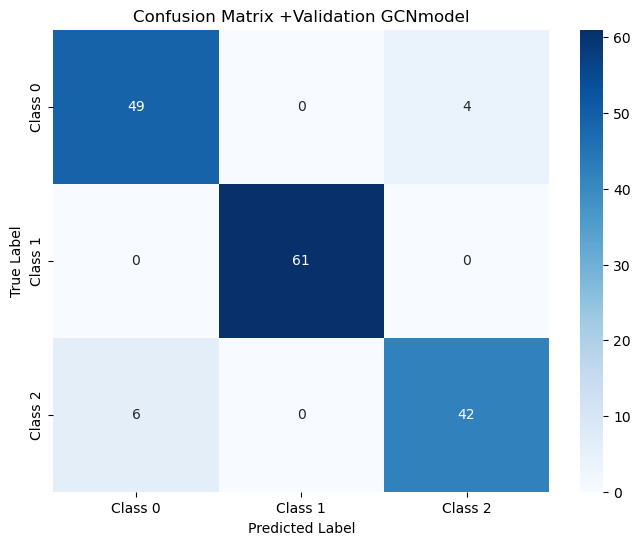

The function took 0.1777 seconds to execute.
Validation Accuracy: 93.8272


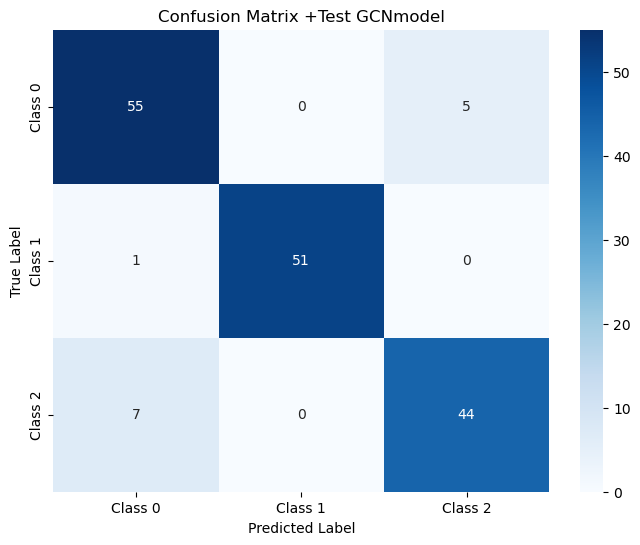

The function took 0.1914 seconds to execute.
Test Accuracy: 92.0245
GraphSAGEmodel


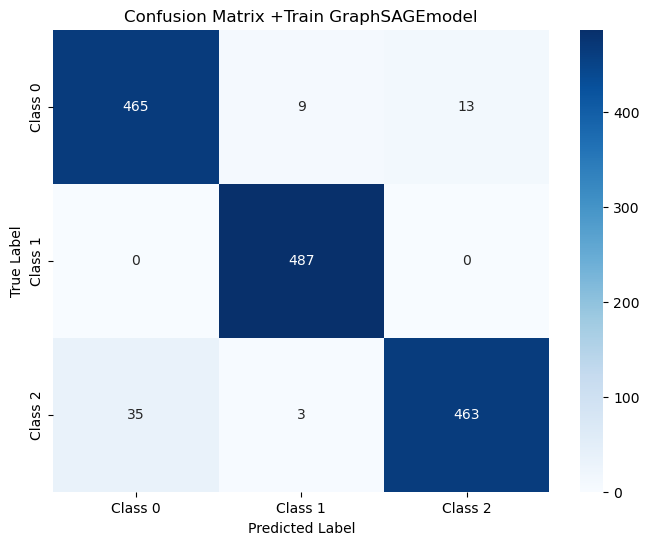

The function took 0.3361 seconds to execute.
Train Accuracy: 95.9322


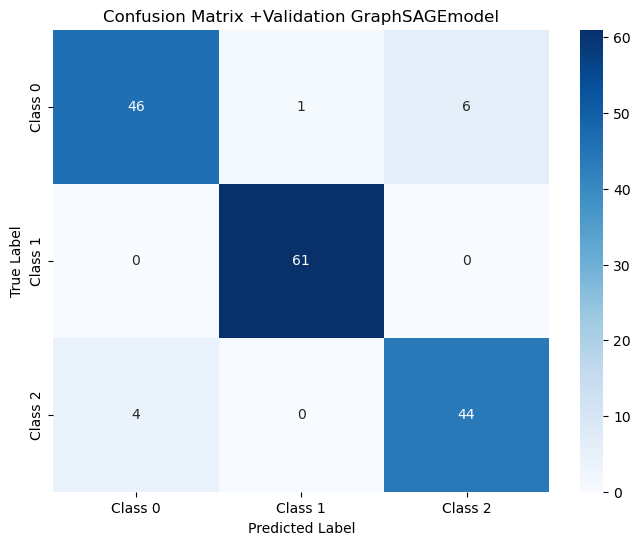

The function took 0.1797 seconds to execute.
Validation Accuracy: 93.2099


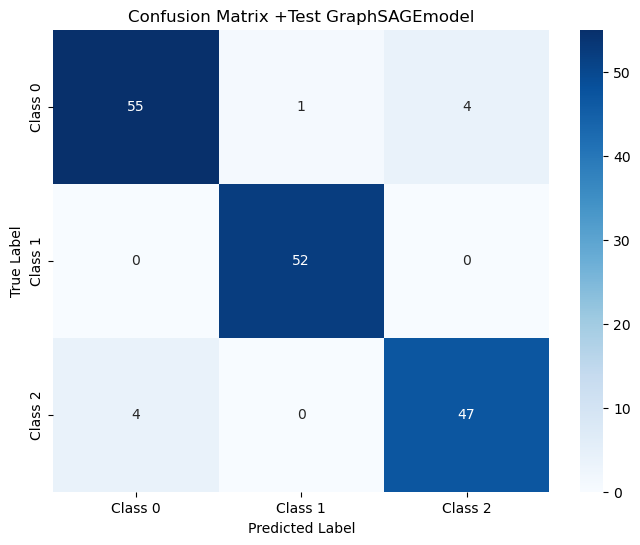

The function took 0.1723 seconds to execute.
Test Accuracy: 94.4785
GATmodel


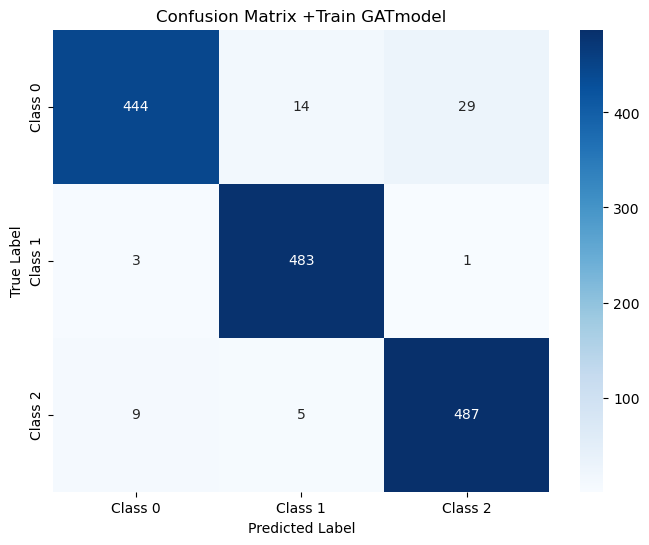

The function took 0.6410 seconds to execute.
Train Accuracy: 95.8644


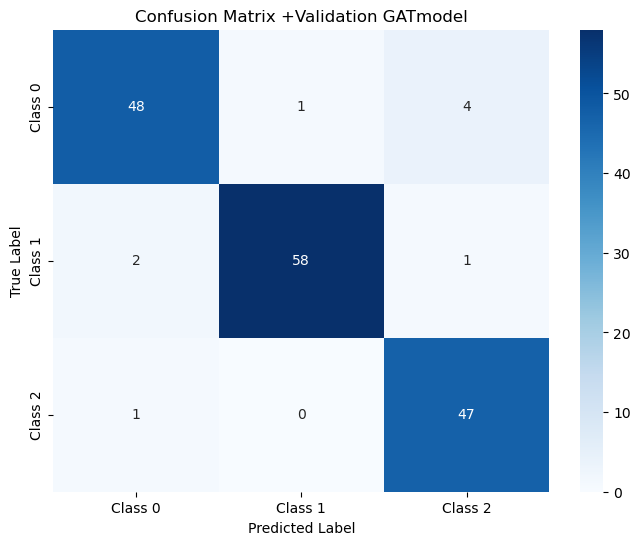

The function took 0.1805 seconds to execute.
Validation Accuracy: 94.4444


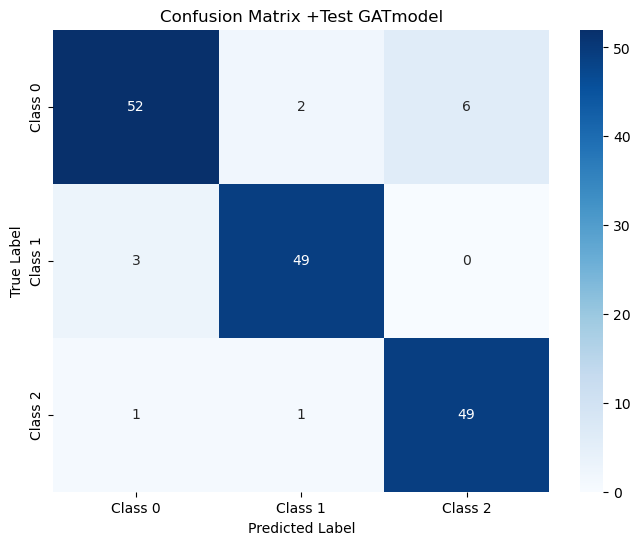

The function took 0.1790 seconds to execute.
Test Accuracy: 92.0245


In [16]:
#Test the models
model_names = ["GCNmodel","GraphSAGEmodel","GATmodel"]
models = [GCNmodel,GraphSAGEmodel,GATmodel]
for i in range(len(model_names)):
    model = models[i]
    print(model_names[i])
    train_accuracy = testing_model(model,train_loader,device,"Train",model_names[i])
    print(f'Train Accuracy: {train_accuracy:.4f}')
    val_accuracy = testing_model(model,val_loader,device,"Validation",model_names[i])
    print(f'Validation Accuracy: {val_accuracy:.4f}')    
    test_accuracy = testing_model(model,test_loader,device,"Test",model_names[i])
    print(f'Test Accuracy: {test_accuracy:.4f}') 